<a href="https://colab.research.google.com/github/jaeheonk817/project_surface-crack-detection/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

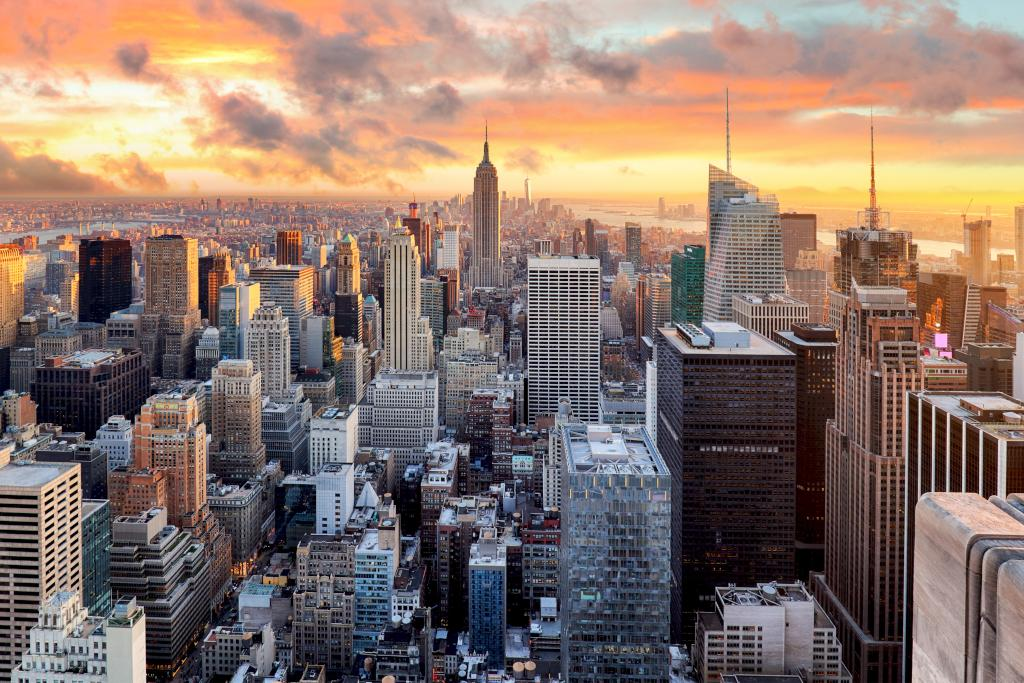

# Surface Crack Detection using CNN for NYC Department of Buildings
authored by Jae Heon Kim

## Overview
This data science project uses the CRISP-DM framework to develop a Convolutional Neural Network (CNN) model for classifying walls as either cracked or not-cracked based on image input. The project aims to provide an automated solution to identify areas for repair and maintenance in buildings. The steps involved include understanding the problem statement and defining the business goal, gathering and preparing the data, developing the model, evaluating its performance, and deploying it for use. The end result is a trained model that can accurately classify walls as cracked or not-cracked based on image input.

## Business Understanding
The stakeholder for this CRISP-DM data science project is the NYC Department of Buildings. The problem they face is that current inspection methods are outdated, costly, time-consuming, and less accurate due to human imperfections. This means that required inspections are not being completed on time, and there is a need for a more efficient and accurate solution. The stakeholder is interested in a model that can help digitize this inspection process, particularly with detecting building cracks. The goal of this project is to train a convolutional neural network (CNN) model that can accurately classify walls as cracked or not-cracked based on image input, thus providing a more automated and accurate solution for building inspections. By achieving this goal, the NYC Department of Buildings can improve the accuracy and efficiency of their inspection process, ultimately leading to cost savings and more timely inspections, which in turn can benefit and protect everyone living and working in New York City.

## Data Understanding
The dataset consists of 40,000 images of concrete surfaces with and without cracks, divided into two separate folders for negative (without crack) and positive (with crack) image classification. Each class has 20,000 images with a resolution of 227 x 227 pixels with RGB channels. The data is generated from 458 high-resolution images (4032x3024 pixel) using the method proposed by Zhang et al. (2016). No data augmentation in terms of random rotation or flipping or tilting is applied. The dataset is contributed by Çağlar Fırat Özgenel and was previously used in a study comparing the performance of pre-trained Convolutional Neural Networks (CNNs) on crack detection in buildings (Özgenel & Gönenç Sorguç, 2018). The dataset can be used for classifying crack and non-crack images and for creating a mask of the cracked portion in new images using image segmentation methods.

Source: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection


The original data was located in a single directory with two categories: positive and negative. After reviewing the data, the data was randomly split into 80% for training, 10% for validation, and 10% for testing using sklearn's train test split. Substantial portion of data was allocated to the training set due to the data's richness, which still allows for good validation and testing sets at this ratio. The process is documented in the `data_prework.ipynb` notebook, which was kept separate from the main notebook to avoid unnecessary complexity and length.


To begin, we will make necessary imports, define relevant functions, and sample some images from the data to survey both cracked and uncracked walls. This will help us get an initial understanding of the data and prepare us for further analysis.

### Imports

In [1]:
# Import basic pacakges
import numpy as np
import pandas as pd

# Import visualization pacakges
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import sklearn packages
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.ensemble import VotingClassifier

# Import tensorflow packages
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.layers import BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras import regularizers
from keras.regularizers import l2
from keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.metrics import Precision, Recall

# Import miscellaneous packesgs
import os
import random

### Functions

In [2]:
# Define a function that plots training history of the model
def plot_training_history(model_history, model_name):
    """This function plots training history of the input model."""
    # Create a figure with two subplots
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
    
    # Plot the training and validation loss in the first subplot
    ax0.plot(model_history.history['loss'], label='Training loss')
    ax0.plot(model_history.history['val_loss'], label='Validation loss')
    ax0.set_xlabel("Epochs")
    ax0.set_ylabel("Binary Cross Entropy")
    ax0.set_title('Training and Validation Loss')
    ax0.legend()
    
    # Plot the traning and validation recall in the first subplot
    ax1.plot(model_history.history['accuracy'], label='Training accuracy')
    ax1.plot(model_history.history['val_accuracy'], label='Validation accuracy')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()
    
    # Set suptitle and plot
    plt.suptitle(f"Training History: {model_name}")
    plt.show()
    
    
    
# Define a function that will print model's metrics on test data
def print_model_metrics(model, model_name):
    """This function prints the model's metrics."""
    global test_data
    
    # Make predictions on the test data
    y_pred_prob = model.predict(test_data)
    y_pred = np.round(y_pred_prob).flatten()

    # Get the true labels from the test data
    y_true = test_data.classes
    
    # Calculate accuracy, precision and recall
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    recall = round(recall_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred), 3)

    # Print accuracy, precision and recall
    print(f"{model_name}'s accuracy: {accuracy}")
    print(f"{model_name}'s precision: {precision}")
    print(f"{model_name}'s recall: {recall}")

    
    
# Define a function that will plot model's confusion matrix based on its results on test data
def plot_confusion_matrix(model, model_name):
    """This function plots the confusion matrix of model's performance on the test data."""
    
    # Make predictions on the test data
    y_pred_prob = model.predict(test_data)
    y_pred = np.round(y_pred_prob).flatten()

    # Get the true labels from the test data
    y_true = test_data.classes
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix using ConfusionMatrixDisplay
    cmd = ConfusionMatrixDisplay(cm, display_labels=['No Crack', 'Crack'])
    cmd.plot(cmap='Blues')
    plt.ylabel("Actual Labels")
    plt.xlabel("Predicted Labels")
    plt.title(f"{model_name}'s Results on Test Data")
    plt.show()
    
    

# Define a function that will display model's metrics
def save_model_metrics(model, model_name):
    """This function prints the model metrics and also saves them to a dictionary."""
    global test_data
    global models_results_dict
    
    # Make predictions on the test data
    y_pred_prob = model.predict(test_data)
    y_pred = np.round(y_pred_prob).flatten()

    # Get the true labels from the test data
    y_true = test_data.classes
    
    # Calculate accuracy, precision and recall
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    recall = round(recall_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred), 3)

    # Store results to the dictionary
    models_results_dict['Model'].append(model_name.title())
    models_results_dict['Accuracy'].append(accuracy)
    models_results_dict['Precision'].append(precision)
    models_results_dict['Recall'].append(recall)
    


# Define a function that will save the model to models directory
def save_model(model, model_name):
    """This function saves the trained model to a separate directory."""
    model.save(os.path.join('models', f"{model_name}.h5"))

### Observing Sample Data
We will randomly select sample pictures to see how our data looks.

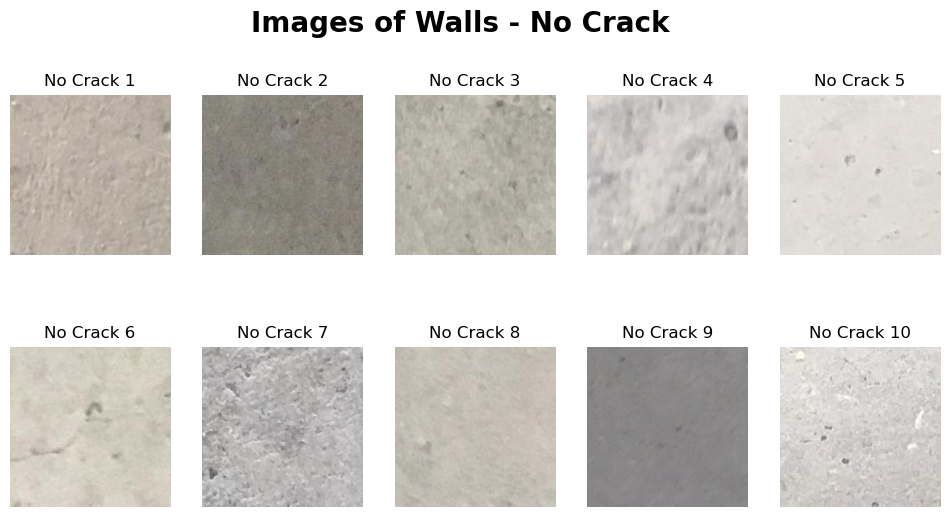

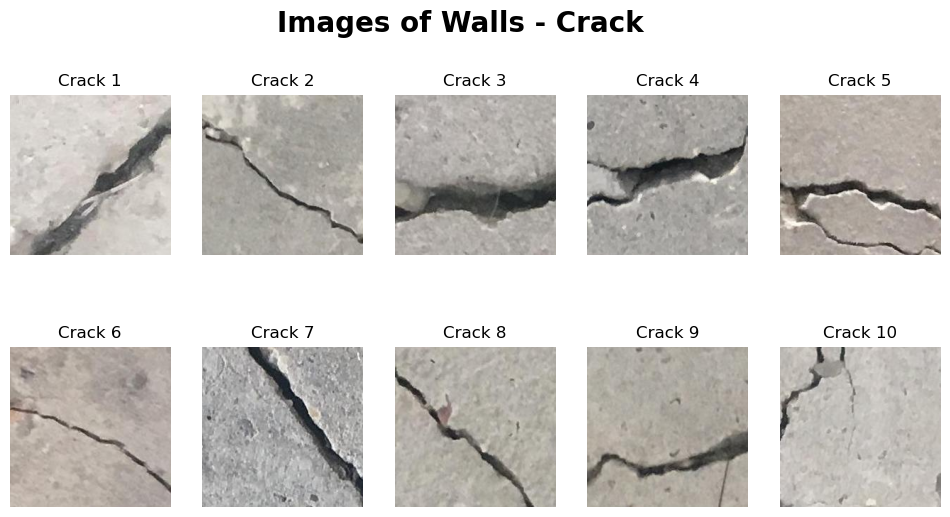

In [3]:
# Assign directory paths to negative and positive data (if on local jupyter notebook)
negative_dir = 'data/train/negative'
positive_dir = 'data/train/positive'

# Randomly pull fifteen negative images
negative_files = os.listdir(negative_dir)
random.shuffle(negative_files)
negative_files_random = negative_files[:15]

# Randomly pull fifteen positive images
positive_files = os.listdir(positive_dir)
random.shuffle(positive_files)
positive_files_random = positive_files[:15]

# Plot random negative images
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    image_path = os.path.join(negative_dir, negative_files_random[i])
    image = plt.imread(image_path)
    ax[row, col].imshow(image)
    ax[row, col].axis('off')
    ax[row, col].set_title(f'No Crack {i+1}')
plt.suptitle("Images of Walls - No Crack", fontsize=20, fontweight='bold')
plt.show()
print("\n"*5)

# Plot random positive images
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    image_path = os.path.join(positive_dir, positive_files_random[i])
    image = plt.imread(image_path)
    ax[row, col].imshow(image)
    ax[row, col].axis('off')
    ax[row, col].set_title(f'Crack {i+1}')
plt.suptitle("Images of Walls - Crack", fontsize=20, fontweight='bold')
plt.show()

- Some no-crack images have patterns that the model can mis interpret as cracks.
- Some crack images have very thin cracks that the model can mistake for a lined pattern.

While most images are easily distinguishable there are some images on the borderline that are difficult to calssify.

## Data Preparation

This section aims to provide a comprehensive overview of data processing techniques that are applicable to all models. However, since we intend to perform specific data processing for each model based on the knowledge gained from the previous one, this section will be brief and straightforward. As we proceed with each model, we can explore and apply more advanced data processing techniques that are tailored to the specific requirements of the model.

### Creating Train, Validation and Test Sets

As explained in `Data Understanding` section earlier, the original data was splitted into three subsets. The work can be found in `data_prework.ipynb` in the root directory. 

### Assinging Paths to Directories

In [4]:
# Assign paths to directories
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

# Assign paths to train directories
train_negative_dir = 'data/train/negative'
train_positive_dir = 'data/train/positive'

# Assign paths to validation directories
val_negative_dir = 'data/val/negative'
val_positive_dir = 'data/val/positive'

# Assign paths to test directories
test_negative_dir = 'data/test/negative'
test_positive_dir = 'data/test/positive'

### Creating Image Data Generators

We will now create a simple, normalized-pixel data generator that we will use for our future models. Validation and test data generators will continue to be same, while train_datagen can differ because of different data augmentationt echniques applied. 

In [5]:
# Define data generators with pixel normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## Modeling

It's finally some time for modeling. Our baseline model will be a cnn model with a single flatten hidden layer. Subsequent models will get more complicated with fine-tuning and other techniques associated with deep-learning image processing. We will save every model and and its metrics. The metrics will be used for comparison choose a final model and we will call back on the saved final model for deployment.

The overall accuracy of a model is undoubtedly crucial, but it's important to consider whether false positives or false negatives are more concerning. False positives may result in a false alarm that triggers a careful survey by human workers at the scene. On the other hand, false negatives can be more problematic as they can endanger individuals who may be inside or near a building with structural damages. Therefore, while the model's goal should be to achieve perfect accuracy, it should prioritize minimizing false negative errors.

We will store the result metrics of each model in the dictionary for comparison purposes later.

In [6]:
# Create a dictionary to store each model's results
models_results_dict = {'Model':[],
                       'Accuracy':[],
                       'Precision':[],
                       'Recall':[]}

### Baseline Model: CNN with One Hidden Layer 
This model is a convolutional neural network with single flatten hidden layer. This model will take color image with a batch size of 512 and run a single epoch for simplicity. This extremely simplified model will enable us to feel the difficulty level of given task.

In [7]:
# Define train_data
train_data = train_datagen.flow_from_directory(train_dir, 
                                               target_size=(128, 128), 
                                               batch_size=512, 
                                               class_mode='binary', 
                                               classes=['negative', 'positive'])

# Define val_data
val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=(128, 128), 
                                           batch_size=512, 
                                           class_mode='binary', 
                                           classes=['negative', 'positive'],
                                           shuffle=False)

# Define test_data
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(128, 128), 
                                             batch_size=512, 
                                             class_mode='binary', 
                                             classes=['negative', 'positive'],
                                             shuffle=False)

Found 32000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [8]:
# Define the model
model_1 = Sequential()
    
# Define layers
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model_1.add(Flatten())
model_1.add(Dense(1, activation='sigmoid'))

# Compile the model
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])

# Train the model
history_1 = model_1.fit(train_data, 
                        epochs=1, 
                        validation_data=val_data)

# Print model summary
model_1.summary()

Metal device set to: Apple M1


2023-04-12 14:07:38.493827: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-12 14:07:38.494063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-12 14:07:38.803267: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-12 14:07:38.962160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 1.9424 - accuracy: 0.7475 - recall: 0.7339

2023-04-12 14:08:08.153814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 31s 480ms/step - loss: 1.9424 - accuracy: 0.7475 - recall: 0.7339 - val_loss: 0.2426 - val_accuracy: 0.9248 - val_recall: 0.8870
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 flatten (Flatten)           (None, 508032)            0         
                                                                 
 dense (Dense)               (None, 1)                 508033    
                                                                 
Total params: 508,929
Trainable params: 508,929
Non-trainable params: 0
_________________________________________________________________


1/8 [==>...........................] - ETA: 1s

2023-04-12 14:09:10.831011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 157ms/step


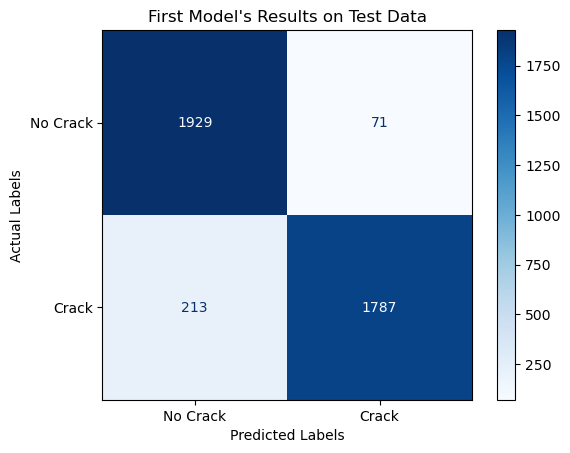

8/8 [==============================] - 1s 142ms/step
First Model's accuracy: 0.929
First Model's precision: 0.962
First Model's recall: 0.894


In [9]:
plot_confusion_matrix(model_1, "First Model")

print_model_metrics(model_1, "First Model")

In [10]:
save_model_metrics(model_1, "First Model")

save_model(model_1, "first_model")

8/8 [==============================] - 1s 139ms/step


- Even the simplest form of model was able to achieve good metrics. This gives us an idea that the nature of task isn't too complicated, along with a motivation to strive for a perfect score.
- We are genuinely concerned more with false negatives. The number of false negatives is greater than false positives, meaning that we may have to customize the activation function in our output layer to address this issue if this situation holds true for our subsequent models. 

### Second Model
This model will have several layers of batch normalization to normalize the output of each layer, improving the stability and speed of the training process. Also, we will take grayscale image for quicker computation.

In [11]:
# Define train_data
train_data = train_datagen.flow_from_directory(train_dir, 
                                               target_size=(128, 128), 
                                               batch_size=128, 
                                               color_mode='grayscale',
                                               class_mode='binary', 
                                               classes=['negative', 'positive'])

# Define val_data
val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=(128, 128), 
                                           batch_size=128, 
                                           color_mode='grayscale',
                                           class_mode='binary', 
                                           classes=['negative', 'positive'],
                                           shuffle=False)

# Define test_data
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(128, 128), 
                                             batch_size=128, 
                                             color_mode='grayscale',
                                             class_mode='binary', 
                                             classes=['negative', 'positive'],
                                             shuffle=False)

Found 32000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [12]:
# Define the model
model_2 = Sequential()
    
# Define layers
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 1)))
model_2.add(BatchNormalization())
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(64))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])

# Train the model
history_2 = model_2.fit(train_data, 
                        epochs=10, 
                        validation_data=val_data)

# Print model summary
model_2.summary()

Epoch 1/10


2023-04-12 14:09:34.016290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 0.1857 - accuracy: 0.9312 - recall_1: 0.9098

2023-04-12 14:13:31.962868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 261s 1s/step - loss: 0.1857 - accuracy: 0.9312 - recall_1: 0.9098 - val_loss: 0.6315 - val_accuracy: 0.7250 - val_recall_1: 0.9655
Epoch 2/10
250/250 [==============================] - 262s 1s/step - loss: 0.0603 - accuracy: 0.9813 - recall_1: 0.9730 - val_loss: 0.4462 - val_accuracy: 0.8603 - val_recall_1: 0.7290
Epoch 3/10
250/250 [==============================] - 262s 1s/step - loss: 0.0385 - accuracy: 0.9883 - recall_1: 0.9824 - val_loss: 0.1013 - val_accuracy: 0.9833 - val_recall_1: 0.9745
Epoch 4/10
250/250 [==============================] - 261s 1s/step - loss: 0.0227 - accuracy: 0.9934 - recall_1: 0.9903 - val_loss: 13.2992 - val_accuracy: 0.8028 - val_recall_1: 0.6115
Epoch 5/10
250/250 [==============================] - 342s 1s/step - loss: 0.0417 - accuracy: 0.9861 - recall_1: 0.9785 - val_loss: 21.7651 - val_accuracy: 0.5068 - val_recall_1: 0.0135
Epoch 6/10
250/250 [==============================] - 262s 1s/step - loss: 0.0386 - 

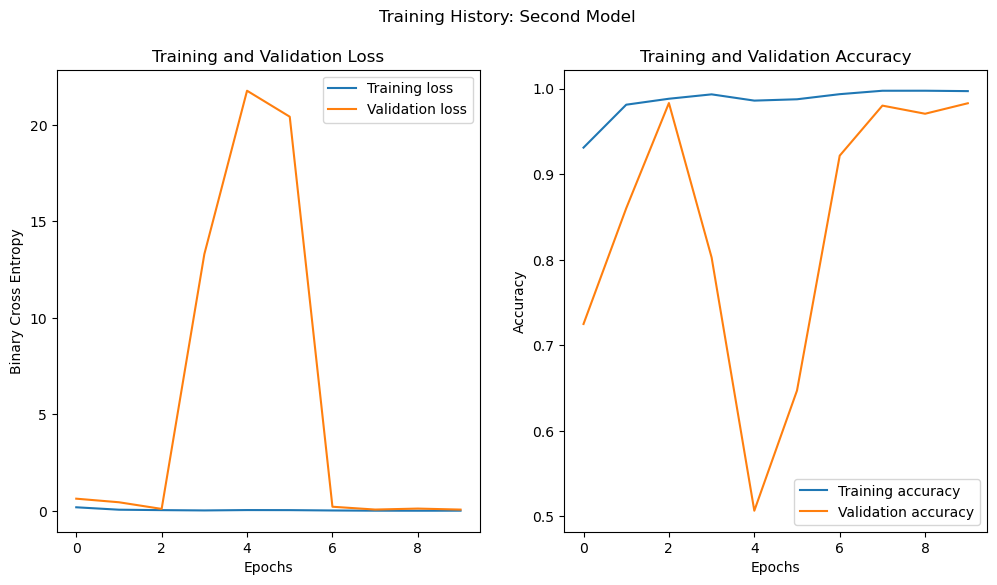

In [13]:
plot_training_history(history_2, "Second Model")

 1/32 [..............................] - ETA: 4s

2023-04-12 14:59:34.950480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 28s 903ms/step


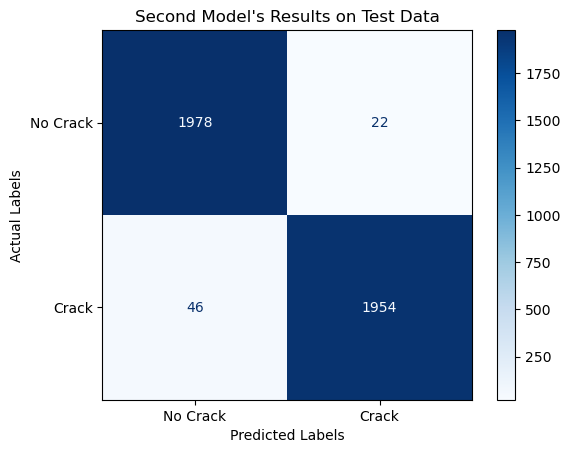

32/32 [==============================] - 28s 905ms/step
Second Model's accuracy: 0.983
Second Model's precision: 0.989
Second Model's recall: 0.977


In [14]:
plot_confusion_matrix(model_2, "Second Model")

print_model_metrics(model_2, "Second Model")

In [15]:
save_model(model_2, "second_model")

save_model_metrics(model_2, "Second Model")

32/32 [==============================] - 28s 907ms/step


- The model's performance was better than expected. All metrics have improved significantly from the first model.
- Nonetheless, since we are dealing with extremely cautious matters, we would like to achieve better metrics.

### Third Model
In the third model, we will apply data augmentation techniques such as zooming, shifting, flipping and rotating so that each input data has more variations. 10 Epochs will be ran. We will use the grayscale one more time because it did so successfully with our last model.

In [16]:
# Define train_data with hyperparameters
train_data = ImageDataGenerator(rescale=1./255,
                                rotation_range=30,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True).flow_from_directory(train_dir, 
                                                                        target_size=(128, 128), 
                                                                        batch_size=128, 
                                                                        color_mode='grayscale',
                                                                        class_mode='binary', 
                                                                        classes=['negative', 'positive'])

# Define val_data
val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=(128, 128), 
                                           batch_size=128, 
                                           color_mode='grayscale',
                                           class_mode='binary', 
                                           classes=['negative', 'positive'],
                                           shuffle=False)

# Define test_data
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(128, 128), 
                                             batch_size=128, 
                                             color_mode='grayscale',
                                             class_mode='binary', 
                                             classes=['negative', 'positive'],
                                             shuffle=False)

Found 32000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [17]:
# Define the model
model_3 = Sequential()
    
# Define layers
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1)))
model_3.add(Flatten())
model_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])

# Train the model
history_3 = model_3.fit(train_data, 
                        epochs=10, 
                        validation_data=val_data)

# Print model summary
model_3.summary()

Epoch 1/10


2023-04-12 15:01:40.987671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 0.4489 - accuracy: 0.8934 - recall_2: 0.8683

2023-04-12 15:02:35.524881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 58s 227ms/step - loss: 0.4489 - accuracy: 0.8934 - recall_2: 0.8683 - val_loss: 0.1888 - val_accuracy: 0.9558 - val_recall_2: 0.9805
Epoch 2/10
250/250 [==============================] - 58s 231ms/step - loss: 0.1297 - accuracy: 0.9615 - recall_2: 0.9416 - val_loss: 0.1720 - val_accuracy: 0.9658 - val_recall_2: 0.9940
Epoch 3/10
250/250 [==============================] - 58s 231ms/step - loss: 0.1034 - accuracy: 0.9687 - recall_2: 0.9522 - val_loss: 0.0960 - val_accuracy: 0.9705 - val_recall_2: 0.9780
Epoch 4/10
250/250 [==============================] - 58s 231ms/step - loss: 0.0892 - accuracy: 0.9710 - recall_2: 0.9550 - val_loss: 0.0997 - val_accuracy: 0.9715 - val_recall_2: 0.9835
Epoch 5/10
250/250 [==============================] - 57s 228ms/step - loss: 0.0802 - accuracy: 0.9741 - recall_2: 0.9597 - val_loss: 0.0681 - val_accuracy: 0.9755 - val_recall_2: 0.9715
Epoch 6/10
250/250 [==============================] - 57s 228ms/step - loss:

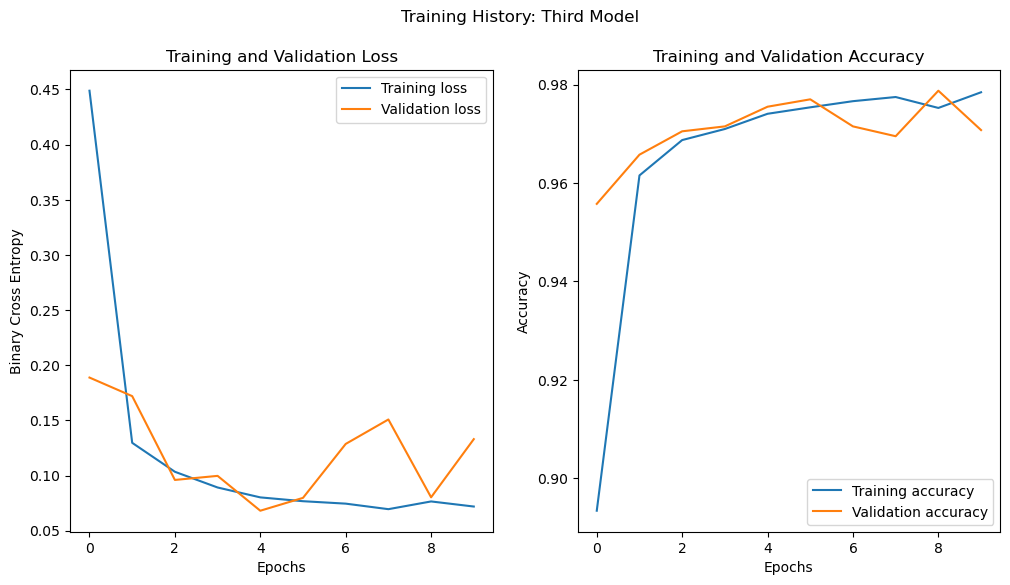

In [18]:
plot_training_history(history_3, "Third Model")

 1/32 [..............................] - ETA: 4s

2023-04-12 15:14:38.364916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 73ms/step


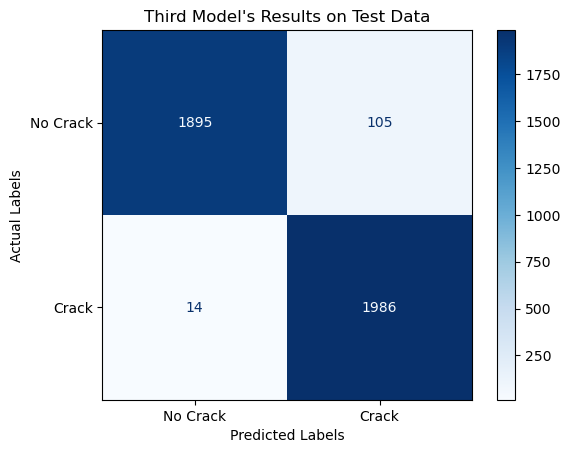

32/32 [==============================] - 2s 63ms/step
Third Model's accuracy: 0.97
Third Model's precision: 0.95
Third Model's recall: 0.993


In [19]:
plot_confusion_matrix(model_3, "Third Model")

print_model_metrics(model_3, "Third Model")

In [20]:
save_model(model_3, "third_model")
save_model_metrics(model_3, "Third Model")

32/32 [==============================] - 2s 69ms/step


- The model has performed noticeably better with recall, but it came at a significant loss of precision score.
- We will only try models that are colorful from this point on.

### Fourth Model
In our fourth model, we will have a simple model with VGG16. The purpose of this model is to view the power of VGG16 without other fine-tuning techniques.

In [21]:
# Define train_data with hyperparameters
train_data = ImageDataGenerator(rescale=1./255,
                                rotation_range=30,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True).flow_from_directory(train_dir, 
                                                                        target_size=(128, 128), 
                                                                        batch_size=128,
                                                                        class_mode='binary', 
                                                                        classes=['negative', 'positive'])

# Define val_data
val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=(128, 128), 
                                           batch_size=128,
                                           class_mode='binary', 
                                           classes=['negative', 'positive'],
                                           shuffle=False)

# Define test_data
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(128, 128), 
                                             batch_size=128,
                                             class_mode='binary', 
                                             classes=['negative', 'positive'],
                                             shuffle=False)

Found 32000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [22]:
# Load the VGG16 model without the top layer
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional base
vgg_model.trainable = False

# Define the model
model_4 = Sequential()
    
# Add the convolutional base as a layer
model_4.add(vgg_model)
          
# Define layers
model_4.add(Flatten())
model_4.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_4.add(Dropout(0.5))
model_4.add(Dense(1, activation='sigmoid'))

# Compile the model
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, min_lr=1e-5)

# Fine-tune the model
history_4 = model_4.fit(train_data, 
                        epochs=6, 
                        validation_data=val_data, 
                        callbacks=[early_stopping, lr_scheduler])

Epoch 1/6


2023-04-12 15:15:06.770282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 0.7023 - accuracy: 0.9729 - recall_3: 0.9763

2023-04-12 15:22:24.036413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 485s 2s/step - loss: 0.7023 - accuracy: 0.9729 - recall_3: 0.9763 - val_loss: 0.0847 - val_accuracy: 0.9983 - val_recall_3: 0.9985 - lr: 0.0010
Epoch 2/6
250/250 [==============================] - 471s 2s/step - loss: 0.1040 - accuracy: 0.9843 - recall_3: 0.9844 - val_loss: 0.0652 - val_accuracy: 0.9975 - val_recall_3: 0.9990 - lr: 0.0010
Epoch 3/6
250/250 [==============================] - 465s 2s/step - loss: 0.0844 - accuracy: 0.9867 - recall_3: 0.9869 - val_loss: 0.0500 - val_accuracy: 0.9983 - val_recall_3: 0.9970 - lr: 0.0010
Epoch 4/6
250/250 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9862 - recall_3: 0.9854
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
250/250 [==============================] - 488s 2s/step - loss: 0.0865 - accuracy: 0.9862 - recall_3: 0.9854 - val_loss: 0.0536 - val_accuracy: 0.9983 - val_recall_3: 0.9985 - lr: 0.0010
Epoch 5/6
250/250 [=======================

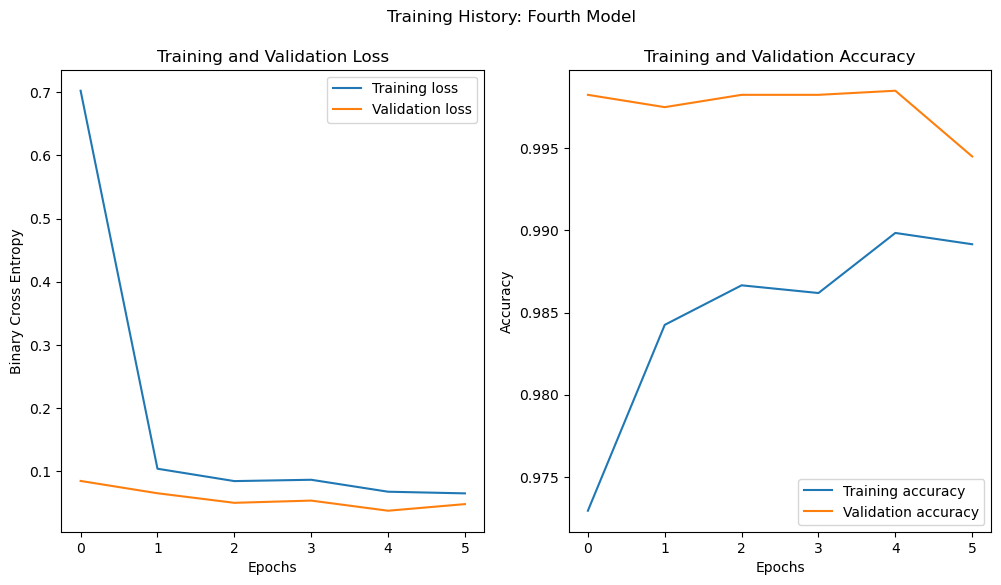

In [23]:
plot_training_history(history_4, "Fourth Model")

2023-04-12 16:09:11.610069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 41s 1s/step


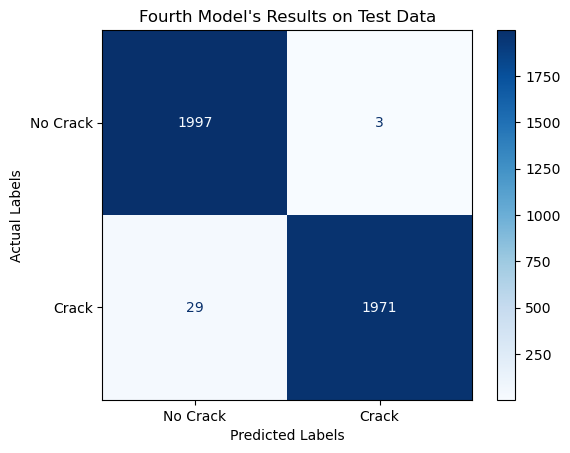

32/32 [==============================] - 41s 1s/step
Fourth Model's accuracy: 0.992
Fourth Model's precision: 0.998
Fourth Model's recall: 0.986


In [24]:
plot_confusion_matrix(model_4, "Fourth Model")

print_model_metrics(model_4, "Fourth Model")

In [25]:
save_model(model_4, "fourth_model")
save_model_metrics(model_4, "Fourth Model")

32/32 [==============================] - 41s 1s/step


- This is our best performing model so far.
- We will try our next model based on this model, by just adding couple more layers to it.

### Fifth Model
This model is a slight evolution from the previous model with added techniques such as batch normalization and more dense layers to enhance performance.

In [26]:
# Define train_data with hyperparameters
train_data = ImageDataGenerator(rescale=1./255,
                                rotation_range=30,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True).flow_from_directory(train_dir, 
                                                                        target_size=(128, 128), 
                                                                        batch_size=128,
                                                                        class_mode='binary', 
                                                                        classes=['negative', 'positive'])

# Define val_data
val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=(128, 128), 
                                           batch_size=128,
                                           class_mode='binary', 
                                           classes=['negative', 'positive'],
                                           shuffle=False)

# Define test_data
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(128, 128), 
                                             batch_size=128,
                                             class_mode='binary', 
                                             classes=['negative', 'positive'],
                                             shuffle=False)

Found 32000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [27]:
# Load the VGG16 model without the top layer, with padding='same'
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in vgg_model.layers:
    if hasattr(layer, 'padding'):
        layer.padding = 'same'
    else:
        print('Layer has no padding attribute:', layer.name)

# Freeze the convolutional base
vgg_model.trainable = False

# Define the model
model_5 = Sequential()

# Add the convolutional base as a layer
model_5.add(vgg_model)

# Define layers
model_5.add(Flatten())
model_5.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))
model_5.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))
model_5.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))
model_5.add(Dense(1, activation='sigmoid'))

# Compile the model
model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, min_lr=1e-5)

# Fine-tune the model
history_5 = model_5.fit(train_data, 
                        epochs=20, 
                        validation_data=val_data, 
                        callbacks=[early_stopping, lr_scheduler])


Layer has no padding attribute: input_2
Epoch 1/20


2023-04-12 16:15:18.463359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 2.0849 - accuracy: 0.9839 - recall_4: 0.9829

2023-04-12 16:23:11.646143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 522s 2s/step - loss: 2.0849 - accuracy: 0.9839 - recall_4: 0.9829 - val_loss: 0.2886 - val_accuracy: 0.9938 - val_recall_4: 0.9995 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - 479s 2s/step - loss: 0.1933 - accuracy: 0.9871 - recall_4: 0.9859 - val_loss: 0.1429 - val_accuracy: 0.9950 - val_recall_4: 0.9990 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9884 - recall_4: 0.9876
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
250/250 [==============================] - 513s 2s/step - loss: 0.1478 - accuracy: 0.9884 - recall_4: 0.9876 - val_loss: 0.1796 - val_accuracy: 0.9733 - val_recall_4: 0.9465 - lr: 0.0010
Epoch 4/20
250/250 [==============================] - 515s 2s/step - loss: 0.0963 - accuracy: 0.9904 - recall_4: 0.9897 - val_loss: 0.0675 - val_accuracy: 0.9993 - val_recall_4: 0.9995 - lr: 5.0000e-04
Epoch 5/20
250/250 [===============

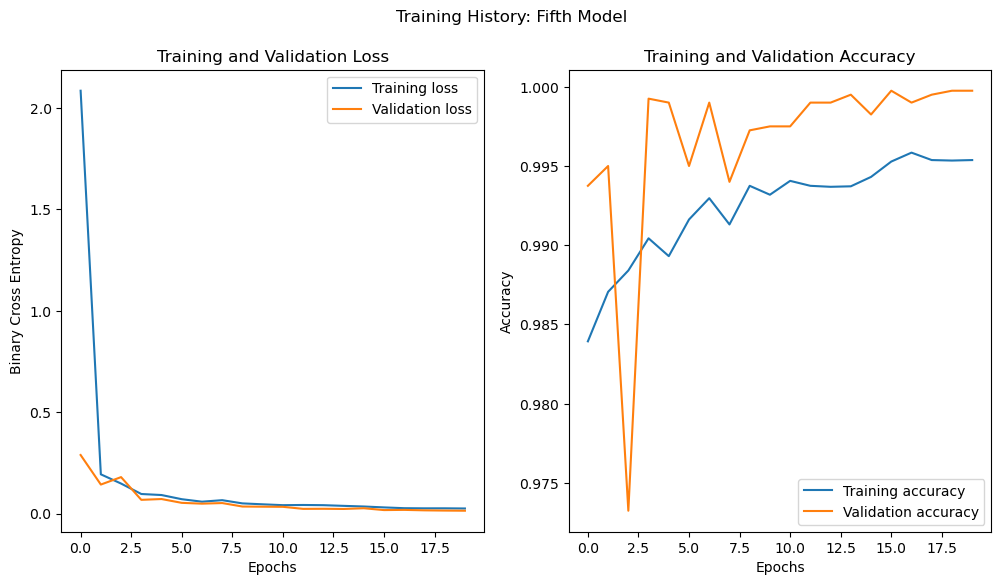

In [28]:
plot_training_history(history_5, "Fifth Model")

2023-04-12 19:10:57.217471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 25s 800ms/step


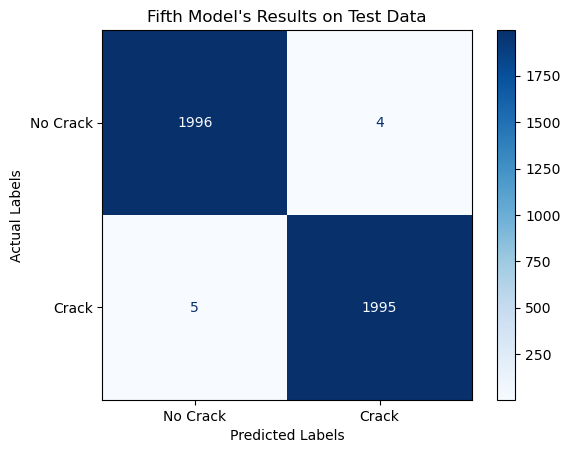

32/32 [==============================] - 25s 806ms/step
Fifth Model's accuracy: 0.998
Fifth Model's precision: 0.998
Fifth Model's recall: 0.998


In [29]:
plot_confusion_matrix(model_5, "Fifth Model")

print_model_metrics(model_5, "Fifth Model")

In [30]:
save_model(model_5, "fifth_model")
save_model_metrics(model_5, "Fifth Model")

32/32 [==============================] - 25s 795ms/step


- This is an unbelievably good result.
- In our next model, we will try the same model except only VGG16 changed for Resnet50.

### Sixth Model
This model will have no variations from the previous model other than having Resnet50 in place of VGG16.

In [31]:
# Load ResNet50 model without top layer
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional base
resnet_model.trainable = False

# Define the model
model_6 = Sequential()

# Add the convolutional base as a layer
model_6.add(resnet_model)

# Define layers
model_6.add(Flatten())
model_6.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.5))
model_6.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.5))
model_6.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.5))
model_6.add(Dense(1, activation='sigmoid'))

# Compile the model
model_6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, min_lr=1e-5)

# Fine-tune the model
history_6 = model_6.fit(train_data, 
                        epochs=20, 
                        validation_data=val_data, 
                        callbacks=[early_stopping, lr_scheduler])

Epoch 1/20


2023-04-12 19:13:09.519283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.6075 - accuracy: 0.9690 - recall_5: 0.9601

2023-04-12 19:15:18.548810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 145s 572ms/step - loss: 1.6075 - accuracy: 0.9690 - recall_5: 0.9601 - val_loss: 1.1377 - val_accuracy: 0.5000 - val_recall_5: 1.0000 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.1849 - accuracy: 0.9770 - recall_5: 0.9739
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
250/250 [==============================] - 167s 669ms/step - loss: 0.1849 - accuracy: 0.9770 - recall_5: 0.9739 - val_loss: 1.9010 - val_accuracy: 0.5707 - val_recall_5: 0.1415 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - 183s 733ms/step - loss: 0.1212 - accuracy: 0.9799 - recall_5: 0.9776 - val_loss: 0.2268 - val_accuracy: 0.9493 - val_recall_5: 0.8985 - lr: 5.0000e-04
Epoch 4/20
250/250 [==============================] - ETA: 0s - loss: 0.1088 - accuracy: 0.9812 - recall_5: 0.9778
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
250/250 [========================

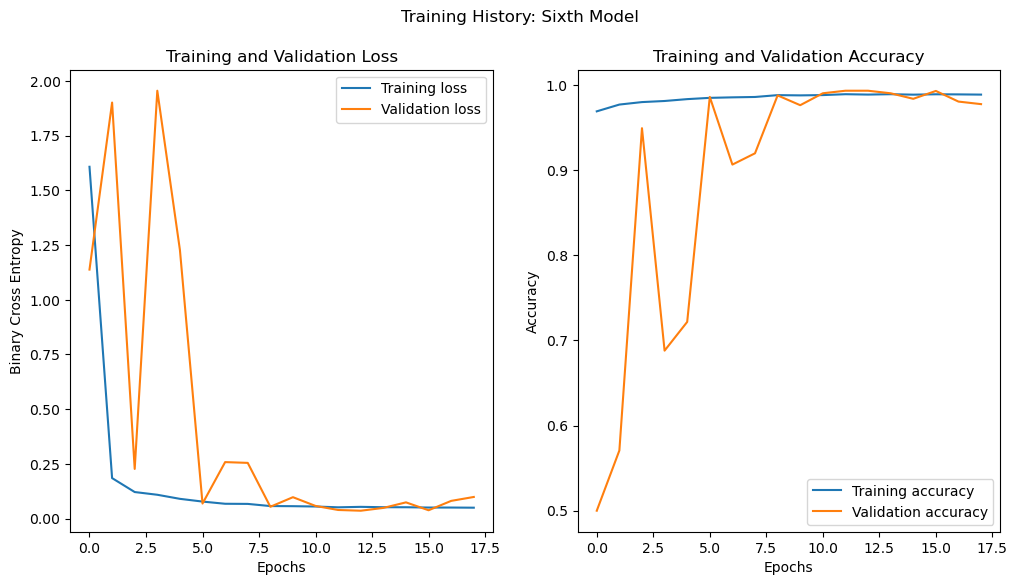

In [32]:
plot_training_history(history_6, "Sixth Model")

2023-04-12 21:18:12.633348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 23s 704ms/step


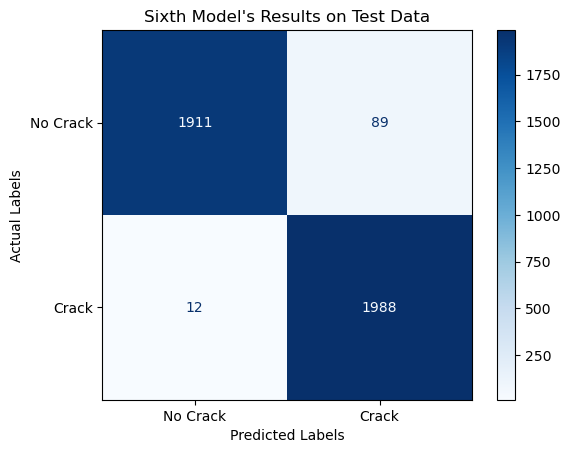

32/32 [==============================] - 22s 692ms/step
Sixth Model's accuracy: 0.975
Sixth Model's precision: 0.957
Sixth Model's recall: 0.994


In [33]:
plot_confusion_matrix(model_6, "Sixth Model")

print_model_metrics(model_6, "Sixth Model")

In [34]:
save_model(model_6, "sixth_model")
save_model_metrics(model_6, "Sixth Model")

32/32 [==============================] - 22s 699ms/step


- Resnet50 is known for processing complicated images. However, for a simple classification task like this, it maybe overly calculating, resulting in more erros than much simpler packages.
- Its performance metrics on false negatives is still great nonetheless.

### Comparing Individual Model Performances

As mentioned many times through this notebook the metric of importance is recall. However, recall is meaningful only after accuracy of prediction is good enough to be qualified as a prediction model. While recall is an important metric to compare the models in choosing our final model, we will also monitor accuracy score closely. Let's make a visualization of our models' performance results on the unseen test data.

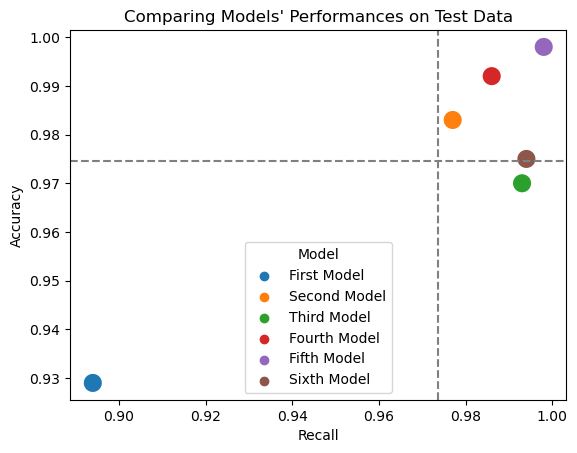

In [100]:
# Create a dataframe of models' performance on test data
models_results_df = pd.DataFrame(models_results_dict)

# Create a visualization
sns.scatterplot(x='Recall', y='Accuracy', hue='Model', s=200, data=models_results_df)
plt.axvline(models_results_df['Recall'].mean(), linestyle='--', color='gray')
plt.axhline(models_results_df['Accuracy'].mean(), linestyle='--', color='gray')
plt.title("Comparing Models' Performances on Test Data")
plt.xlabel("Recall")
plt.ylabel("Accuracy")
plt.show()

- The dotted vertical line is the average of all recall values.
- The dotted horizontal line is the average of all accuracy values.
- Fifth model is absolutely our top performer in all metrics. We will choose it as our final model for deployment.

## Evaluation
We will start our evaluation by viewing the final model's architecture.

In [38]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               4194816   
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                      

The model starts off with a VGG16 layer followed by a flattening layer. Then it goes through a series of batch normalization and dense layers with dropouts to inactivate unimportant nodes. The final layer's activation function is sigmoid since this is a binary classification problem.

We will now check images of 4 false positives and 5 false negatives.

In [80]:
y_pred_prob = model_5.predict(test_data)
y_pred = np.round(y_pred_prob).flatten()

# Get the true labels from the test data
y_true = test_data.classes

32/32 [==============================] - 42s 1s/step


In [81]:
# Find the indices of the false negative samples
false_negatives = np.where((y_true == 1) & (y_pred == 0))[0]
false_positives = np.where((y_true == 0) & (y_pred == 1))[0]

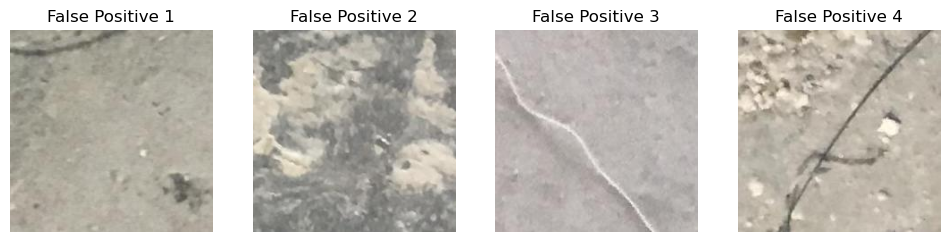

In [92]:
# Plot false positive images
fig, ax = plt.subplots(1, 4, figsize=(12, 6))
for i in range(4):
    false_positive = false_positives[i]
    image_path = os.path.join(test_dir, test_data.filenames[false_positive])
    image = plt.imread(image_path)
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i].set_title(f'False Positive {i+1}')
plt.show()

- `False Positive 1` has a line shape in upper left that could have been mistaken for a crack.
- `False Positive 2` has no clear reason as to why it can be mistaken for a cracked wall.
- `False Positive 3` has a linear pattern that can be mistaken for a crack which to humans eys shouldn't be mistaken.
- `False Positive 4` seems like the image actually has a crack but mislabled by humans compiling the data.

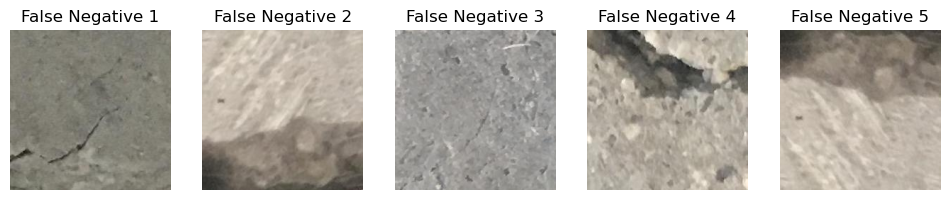

In [93]:
# Plot false positive images
fig, ax = plt.subplots(1, 5, figsize=(12, 6))
for i in range(5):
    false_negative = false_negatives[i]
    image_path = os.path.join(test_dir, test_data.filenames[false_negative])
    image = plt.imread(image_path)
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i].set_title(f'False Negative {i+1}')
plt.show()

- `False Negative 1` has a slight divergence visible to naked human eyes.
- `False Negative 3` seemingly has no crack, or maybe a very slight one. This is hard to notice.
- `False Negatives 2, 4, 5` all have crackes on the edge of their images. The model needs to be trained on such occasions since 60% of false negative errors are this type.

## Conclusion

### Final Model's Performance
- The final model's accuracy of 99.8% is an increase of 6.9% from baseline model's accuracy of 92.9%.
- The final model's recall of 99.8% is an increase of 10.4% from baseline model's recall of 89.4%
- Some of wrongly predicted images are difficult for human eyes to judge as well.
- This model will allow for a near-perfect classification at a tiny fraction of time humans perform the job.

### Reccommendations to NYC Department of Buildings:
- Optimize human resources and cut costs by deploying less specialized personnel for inspection tasks that can be simplified through the use of this model. Rather than hiring expensive, over-qualified inspectors, consider deploying less expensive personnel to simply capture images for inspections. This approach will not only significantly cut costs, but also allow for more inspections that are currently behind schedule.

- Leverage the power of the New York City Department of Buildings to gather more data for building inspections. Since buildings are often private properties, it can be challenging for third-party inspection companies to obtain detailed data. However, by utilizing the lawful power granted to the NYC Department of Buildings, we can gather more 2D and 3D data about buildings, which can be used not only for building inspections, but also for a wide range of future applications that may not yet be fully realized.

- Use the crack detection model to gather time-series image data for early identification of potential cracks. By monitoring the evolving condition of building walls over time, the inspection company can identify walls that have a higher risk of developing cracks, and take proactive measures to prevent further damage. This can save the building owner significant costs and resources, and enhance the inspection company's reputation as a trusted and reliable service provider. Building a time-series model for building condition prediction can help judge a building not only on the face value of its current status but also on overall degrading pace over time and where it's going.

## Next Steps

- Collect more diverse data sets, including images taken from various distances and angles, with obstacles present in the background.
- Train the model on moving images (3D) to expedite the inspection process and provide inspectors with a point-of-view camera to capture images for analysis.
- Enhance the model's capabilities by expanding it to include the detection of other building features, such as rotting and rat holes.
- Test the model with a larger and more diverse set of data using the Streamlit platform to evaluate and refine its performance.
- Incorporate additional training data that includes images that were not previously seen to continue improving the model's accuracy.
- Create an ensemble model, such as a voting classifier, that combines multiple well-performing models of different types to account for the weaknesses of any single model and improve the accuracy and usefulness of the overall system.